In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os
import pickle
from utils.functions import sample, get_error_term
from model.vae_model import vae_model

In [2]:
raw_dt = pd.read_csv("data/realTweets/realTweets/Twitter_volume_CRM.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2015-02-26 21:42:53,11
1,2015-02-26 21:47:53,10
2,2015-02-26 21:52:53,3
3,2015-02-26 21:57:53,4
4,2015-02-26 22:02:53,9


Text(0.5, 1.0, 'Original Dataset')

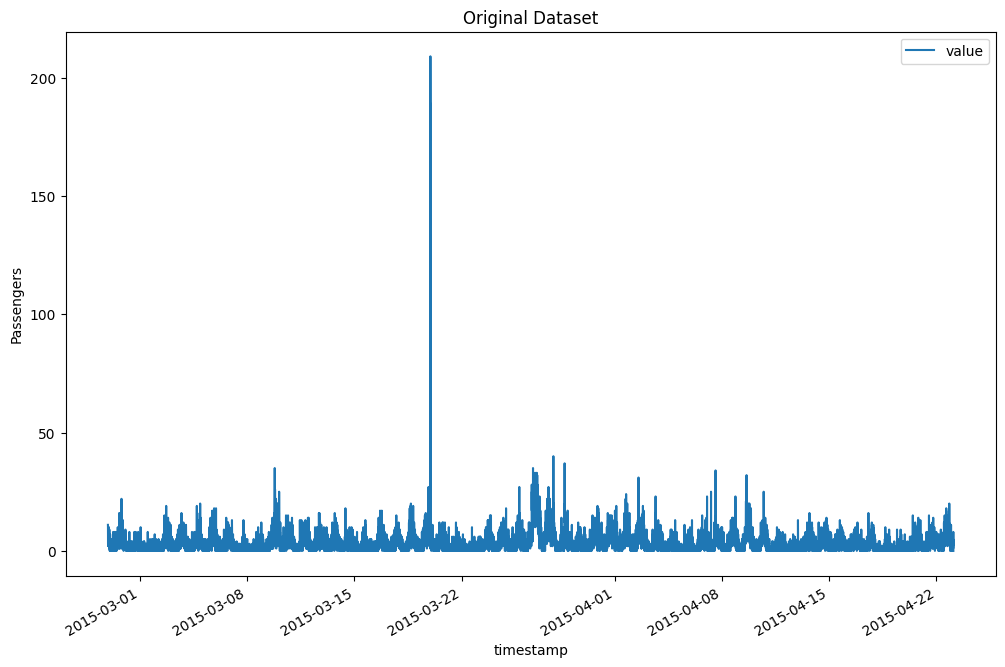

In [3]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("Passengers")
plt.title("Original Dataset")

In [4]:
data['label'] = 0
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances= lists[1]

In [5]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 1

In [6]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2015-02-26 21:42:53,11,0
1,2015-02-26 21:47:53,10,0
2,2015-02-26 21:52:53,3,0
3,2015-02-26 21:57:53,4,0
4,2015-02-26 22:02:53,9,0
...,...,...,...
15897,2015-04-23 02:27:53,1,0
15898,2015-04-23 02:32:53,4,0
15899,2015-04-23 02:37:53,3,0
15900,2015-04-23 02:42:53,8,0


In [7]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week
0,2015-02-26 21:42:53,11,0,26,2,21.700000,3
1,2015-02-26 21:47:53,10,0,26,2,21.783333,3
2,2015-02-26 21:52:53,3,0,26,2,21.866667,3
3,2015-02-26 21:57:53,4,0,26,2,21.950000,3
4,2015-02-26 22:02:53,9,0,26,2,22.033333,3


In [8]:
cont_vars = ['value', 'hour_min']
cat_vars = ['day', 'month', 'day_of_week']
data.drop('timestamp', axis=1, inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,11,0,21.700000,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,10,0,21.783333,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
2,3,0,21.866667,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
3,4,0,21.950000,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,9,0,22.033333,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,1,0,2.450000,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,4,0,2.533333,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,3,0,2.616667,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,8,0,2.700000,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [10]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'day_0', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'month_0',
       'month_1', 'month_2', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')


In [11]:
# Splitting to train and test
train_start = int(len(data) * 0.55)
test_end =  int(len(data) * 0.25)
tr_data = data.iloc[ train_start :]
tst_data = data.iloc[: test_end]

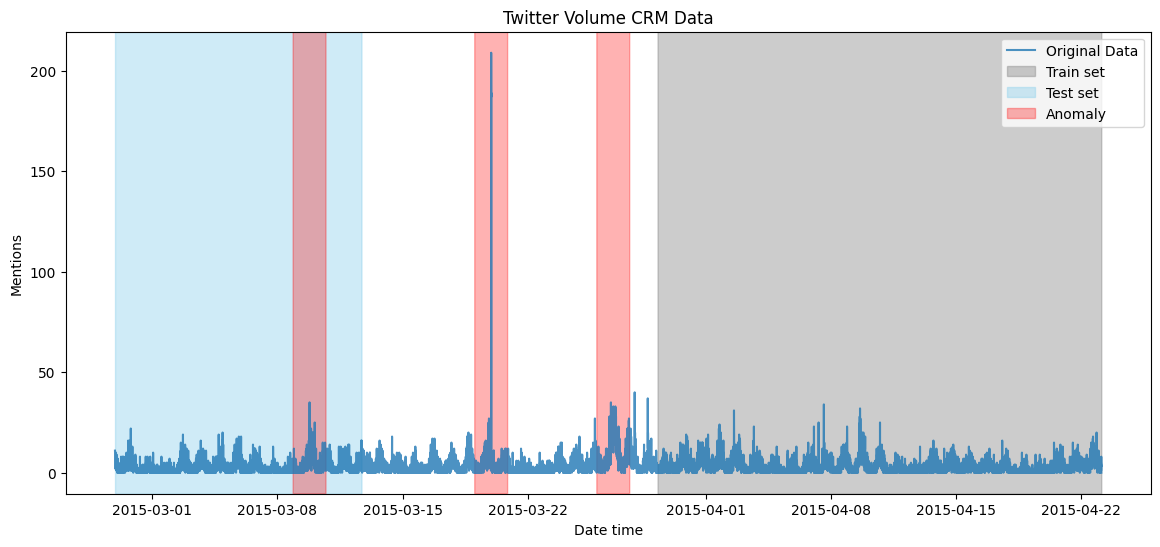

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.8)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=(data_w_ts['timestamp'] > data_w_ts['timestamp'].iloc[train_start]) & (data_w_ts['timestamp'] < data_w_ts['timestamp'].iloc[len(data)-1]), color='gray', alpha=0.4, transform=ax.get_xaxis_transform(),label='Train set')
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=(data_w_ts['timestamp'] > data_w_ts['timestamp'].iloc[0]) & (data_w_ts['timestamp'] < data_w_ts['timestamp'].iloc[test_end]), color='skyblue', alpha=0.4, transform=ax.get_xaxis_transform(),label='Test set')
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=(data_w_ts['label']), color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Anomaly')
plt.title('Twitter Volume CRM Data')
plt.xlabel('Date time')
plt.ylabel('Mentions')
plt.legend()

In [13]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [14]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [15]:
tr_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
8746,-0.653753,0,-0.794724,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8747,-0.653753,0,-0.782690,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8748,-0.355718,0,-0.770656,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8749,-0.653753,0,-0.758622,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8750,-0.653753,0,-0.746589,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,-0.653753,0,-1.384379,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,0.240352,0,-1.372345,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,-0.057683,0,-1.360311,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,1.432493,0,-1.348277,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [16]:
tst_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2.326598,0,1.395424,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,2.028563,0,1.407457,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
2,-0.057683,0,1.419491,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
3,0.240352,0,1.431525,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,1.730528,0,1.443559,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3970,2.326598,0,0.649330,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
3971,1.432493,0,0.661363,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
3972,0.240352,0,0.673397,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
3973,-0.653753,0,0.685431,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False


In [17]:
train = tr_data_scaled[tr_data_scaled.label != 1]
train= train.drop(columns=['label'])
train

,value,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,month_0,month_1,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
8746,-0.653753,-0.794724,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8747,-0.653753,-0.782690,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8748,-0.355718,-0.770656,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8749,-0.653753,-0.758622,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8750,-0.653753,-0.746589,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15897,-0.653753,-1.384379,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15898,0.240352,-1.372345,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15899,-0.057683,-1.360311,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
15900,1.432493,-1.348277,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [18]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [19]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [20]:
vae_model = vae_model(train)

vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 21)        │        924 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 14)        │      1,540 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 21)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 43)        │      1,261 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 14)        │        308 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 14)        │        308 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 43)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1751.4990 - val_loss: 1507.3043
Epoch 2/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1694.0637 - val_loss: 1458.9541
Epoch 3/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1643.8683 - val_loss: 1419.5988
Epoch 4/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1598.0573 - val_loss: 1382.3759
Epoch 5/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1560.6383 - val_loss: 1334.7379
Epoch 6/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1528.5663 - val_loss: 1293.9084
Epoch 7/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1472.7778 - val_loss: 1253.9821
Epoch 8/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1441.2220 - val_loss: 1208.6688
Epoch 9/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1392.7662 - val_loss: 1169.1530
Epoch 10/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1357.8004 - val_loss: 1120.7203
Epoch 11/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1308.7701 - val_lo

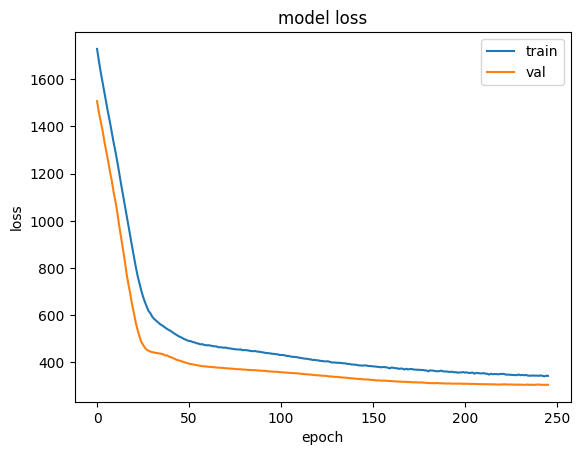

In [21]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [22]:
train_pred = vae_model.predict(train)[0]

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


In [23]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}')
error_thresh = np.max(mae_vector) -0.01
print(f'setting threshold on {error_thresh} ')

Avg error 0.21010836958885193
median error 0.19841977953910828
setting threshold on 1.2578236961364746 


(array([7.500e+01, 2.380e+02, 4.320e+02, 9.090e+02, 1.344e+03, 1.166e+03,
        9.640e+02, 6.670e+02, 5.200e+02, 4.050e+02, 2.340e+02, 6.600e+01,
        2.800e+01, 2.500e+01, 1.200e+01, 8.000e+00, 9.000e+00, 6.000e+00,
        4.000e+00, 2.000e+00, 9.000e+00, 2.000e+00, 2.000e+00, 5.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.06814718, 0.09214071, 0.11613424, 0.14012778, 0.1641213 ,
        0.18811484, 0.21210836, 0.2361019 , 0.26009542, 0.28408897,
        0.30808249, 0.33207601, 0.35606954, 0.38006309, 0.40405661,
        0.42805013, 0.45204365, 0.4760372 , 0.50003076, 0.52402425,
        0.5480178 , 0.57201129, 0.59600484, 0.6199984 , 0.64399189,
        0.66798544, 0.69197899, 0.71

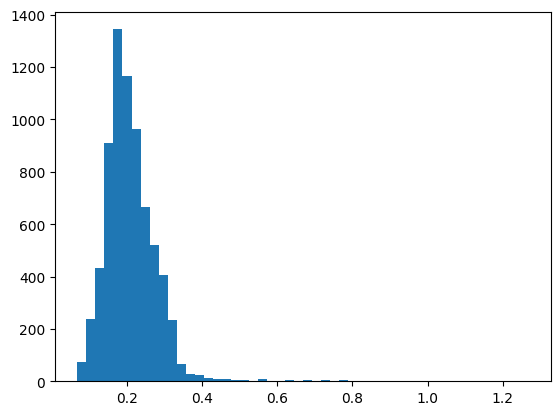

In [24]:
plt.hist(mae_vector, bins=50)

In [25]:
#Actual ratio of anomalies 
ratio=np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.13358490566037737


In [26]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
Avg error 0.2940782904624939
median error 0.29327329993247986


0.00025157232704402514

(array([267., 342., 366., 470., 610., 667., 547., 310., 207.,  96.,  21.,
         21.,   7.,   5.,   5.,   5.,   5.,   2.,   4.,   4.,   1.,   3.,
          1.,   0.,   2.,   1.,   0.,   0.,   2.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.18092175, 0.20384379, 0.22676581, 0.24968785, 0.27260989,
        0.2955319 , 0.31845394, 0.34137598, 0.36429802, 0.38722005,
        0.41014206, 0.4330641 , 0.45598614, 0.47890818, 0.50183022,
        0.52475226, 0.5476743 , 0.57059628, 0.59351832, 0.61644036,
        0.63936239, 0.66228443, 0.68520647, 0.70812851, 0.73105055,
        0.75397259, 0.77689463, 0.79981661, 0.82273865, 0.84566069,
        0.86858273, 0.89150476, 0.9144268 , 0.93734884, 0.96027088,
        0.98319292, 1.00611496, 1.029037  , 1.05195904, 1.07488108,
        1.09780312, 1.12072504, 1.14364707, 1.16656911, 1.18949115,
        1.21241319, 1.23533523, 1.25825727, 1.

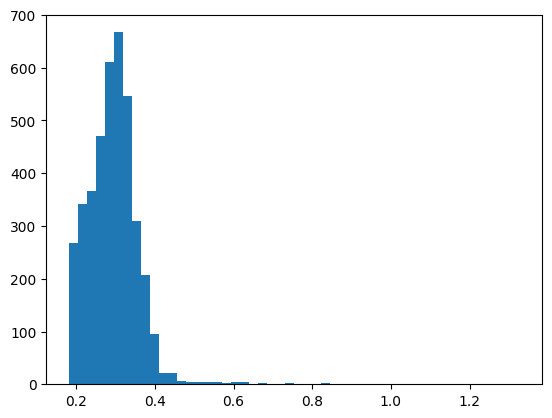

In [27]:
plt.hist(mae_vector_test, bins=50)

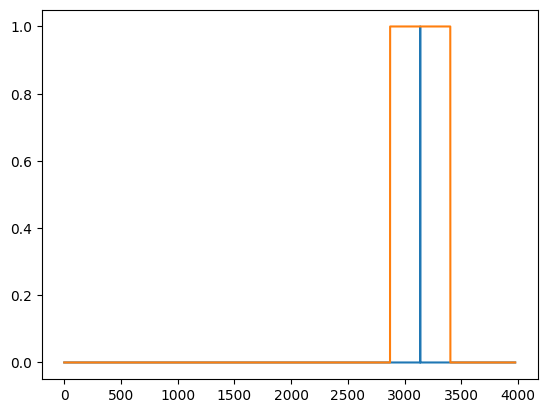

In [28]:
plt.plot(anomalies)
plt.plot(labels_of_test)

In [29]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.13      1.00      0.24       531
        True       0.00      0.00      0.00      3444

    accuracy                           0.13      3975
   macro avg       0.07      0.50      0.12      3975
weighted avg       0.02      0.13      0.03      3975



In [31]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[:test_end]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

C:\Users\99anj\AppData\Local\Temp\ipykernel_22860\2980159921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_22860\2980159921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


Text(0.5, 1.0, 'Location of the Anomalies on the Test set')

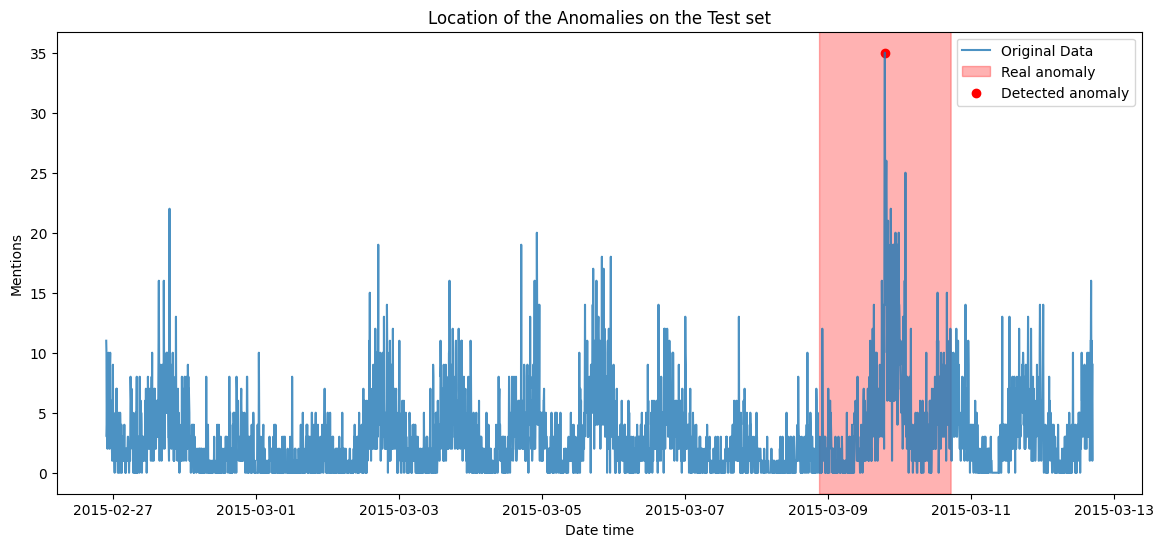

In [41]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==1, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'].iloc[:test_end], data_w_ts['value'].iloc[:test_end], label='Original Data', alpha=0.8)
ax.fill_between(data_w_ts['timestamp'].iloc[:test_end], 0, 1, where=data_w_ts['label'].iloc[:test_end], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Realll anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='red', label='Detected anomaly')
plt.legend()
plt.xlabel('Date time')
plt.ylabel('Mentions')
plt.title("Location of the Anomalies on the Test set")

In [36]:
from utils.scoring import score_fn
anomaly_ranges = [(datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f"), 
                       datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f")) for start, end in instances[:1]]
res = score_fn(testing['timestamp'], anomaly_ranges)
print (res)
print (f'Score: {np.sum(res)}')

[1, 0]
Score: 1
